reference
- https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_albert.py
- https://github.com/google-research/ALBERT/blob/master/modeling.py

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from functools import reduce

In [2]:
def get_num_params(model):
    n_params = 0
    for param in model.parameters():
        param_shape = list(param.shape)
        n_params += reduce(lambda x, y: x*y, param_shape)
    return n_params

#### input/output embedding

In [3]:
from transformers import BertModel, BertTokenizer
import torch

In [4]:
model_nm = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_nm)
model = BertModel.from_pretrained(model_nm)

In [5]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [6]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [7]:
emb_output = model.embeddings(input_ids)
emb_output.shape

torch.Size([1, 8, 1024])

In [8]:
attention_mask = torch.ones(input_ids.shape)
extended_attention_mask = attention_mask[:, None, None, :]
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [9]:
n_layers = model.config.num_hidden_layers
n_layers

24

In [10]:
head_mask = [None] * n_layers

In [11]:
trans = model.encoder(emb_output, extended_attention_mask, head_mask)

In [12]:
trans[0].shape, trans[0].sum()

(torch.Size([1, 8, 1024]), tensor(-27.9191, grad_fn=<SumBackward0>))

In [13]:
hidden_states = emb_output
dist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
distance_list = []

for i, layer in enumerate(model.encoder.layer):
    input_embedding = hidden_states
    out = layer(
        hidden_states,
        extended_attention_mask,
        head_mask[i],
    )
    output_embedding = out[0]
    distance = torch.dist(input_embedding, output_embedding, p=2)
    distance_list.append(distance)
    print(i, input_embedding.shape, output_embedding.shape, distance)

0 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(35.7552, grad_fn=<DistBackward>)
1 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(40.1659, grad_fn=<DistBackward>)
2 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(42.7441, grad_fn=<DistBackward>)
3 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(42.5579, grad_fn=<DistBackward>)
4 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(45.1392, grad_fn=<DistBackward>)
5 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(37.5907, grad_fn=<DistBackward>)
6 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(36.1166, grad_fn=<DistBackward>)
7 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(40.5871, grad_fn=<DistBackward>)
8 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(50.8445, grad_fn=<DistBackward>)
9 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(51.9049, grad_fn=<DistBackward>)
10 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(57.1084, grad_fn=<Di

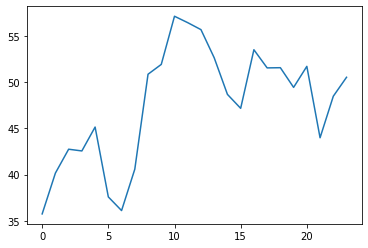

In [14]:
import matplotlib.pyplot as plt
plt.plot(distance_list)
plt.show()

#### Can BERT do SOP?

In [15]:
import numpy as np
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction
#from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction

ModuleNotFoundError: No module named 'pytorch_pretrained_bert'

In [16]:
model_nm = 'bert-base-uncased'

In [3]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(model_nm)

In [12]:
# NSP label should be 0
sent_1 = 'How old are you?'
sent_2 = 'I am 35 years old'

# NSP label should be 1
sent_1 = 'How old are you?'
sent_2 = 'The Eiffel Tower is in Paris'

sent_1 = 'is Obama the president of the US?'
sent_2 = 'No but he was'

In [16]:
# Tokenized input
text = ' '.join(['[CLS]', sent_1, '[SEP]', sent_2, '[SEP]'])
text = ' '.join(['[CLS]', sent_2, '[SEP]', sent_1, '[SEP]'])
tokenized_text = tokenizer.tokenize(text)

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = (len(tokenizer.tokenize(sent_1))+2)*[0] + (len(tokenizer.tokenize(sent_2))+1)*[1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [6]:
# Load pre-trained model (weights)
model = BertForNextSentencePrediction.from_pretrained(model_nm)
model.eval()

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, eleme

In [17]:
output = model(tokens_tensor, segments_tensors)
logits = output[0]
logits

tensor([ 5.5330, -4.8882], grad_fn=<SelectBackward>)

In [18]:
if logits[0] < logits[1]:
    print('they are random sentences')
else:
    print('they are in relation')

they are in relation


#### BERT weight visualizationm

In [1]:
from transformers import BertTokenizer, BertModel, BertConfig
from functools import reduce
import torch
import seaborn as sns
import numpy as np
import seaborn as sns

In [2]:
model_nm = 'bert-large-uncased'
conf = BertConfig.from_pretrained(model_nm)
tokenizer = BertTokenizer.from_pretrained(model_nm)
model = BertModel.from_pretrained(model_nm)

In [3]:
sent_1 = 'I like an apple'
sent_2 = 'You like a banana'
sent = ' '.join([sent_1, '[SEP]', sent_2])

In [16]:
sent

'I like an apple [SEP] You like a banana'

In [4]:
input_ids_1 = torch.tensor(tokenizer.encode(sent_1, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
input_ids_2 = torch.tensor(tokenizer.encode(sent_2, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
#input_ids = torch.tensor(tokenizer.encode(sent, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
input_ids = torch.tensor(tokenizer.encode(sent_1, add_special_tokens=True)).unsqueeze(0)  # Batch size 1

In [5]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.detach().numpy()[0])
idx = tokens.index('[SEP]')
token_ids = np.ones(len(tokens)).astype(np.int)
token_ids[idx+1:] = 1
token_ids = torch.tensor(token_ids).unsqueeze(0)
token_ids.shape

torch.Size([1, 6])

In [6]:
position_ids = torch.arange(len(tokens), dtype=torch.long)
position_ids = position_ids.unsqueeze(0).expand(input_ids.shape)
position_ids.shape

torch.Size([1, 6])

In [7]:
embedding_out_1 = model.embeddings(input_ids, token_type_ids=token_ids, position_ids=position_ids)
embedding_out_1.shape

torch.Size([1, 6, 1024])

In [8]:
self_attention = model.encoder.layer[0].attention.self

In [9]:
q_layer = self_attention.query(embedding_out_1)
k_layer = self_attention.key(embedding_out_1)
v_layer = self_attention.value(embedding_out_1)
q_layer.shape, k_layer.shape, v_layer.shape

(torch.Size([1, 6, 1024]), torch.Size([1, 6, 1024]), torch.Size([1, 6, 1024]))

In [10]:
def transpose_for_scores(x):
    new_x_shape = x.size()[:-1] + (conf.num_attention_heads, conf.hidden_size//conf.num_attention_heads)
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [11]:
q_layer = transpose_for_scores(q_layer)
k_layer = transpose_for_scores(k_layer)
v_layer = transpose_for_scores(v_layer)
q_layer.shape, k_layer.shape, v_layer.shape

(torch.Size([1, 16, 6, 64]),
 torch.Size([1, 16, 6, 64]),
 torch.Size([1, 16, 6, 64]))

In [12]:
score = torch.matmul(q_layer, k_layer.transpose(-1, -2))
prob = torch.nn.Softmax(dim=-1)(score)
score.shape, prob.shape

(torch.Size([1, 16, 6, 6]), torch.Size([1, 16, 6, 6]))

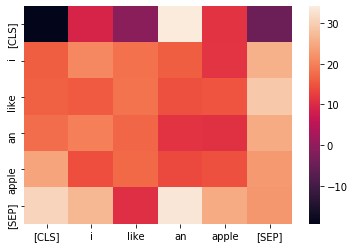

In [13]:
ax = sns.heatmap(score[0][0].detach().numpy(), xticklabels=tokens, yticklabels=tokens)

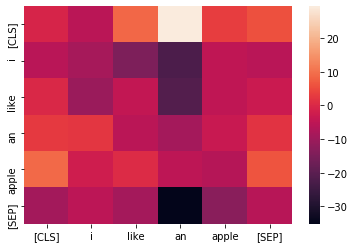

In [14]:
ax = sns.heatmap(score[0][-1].detach().numpy(), xticklabels=tokens, yticklabels=tokens)

In [15]:
for i, sc in enumerate(score[0][-1]):
    idx = np.argsort(sc.detach().numpy())
    maxidx = np.argsort(sc.detach().numpy())[::-1]
    maxword = list(map(lambda idx: tokens[idx], maxidx))
    print(tokens[i], maxword[:5])

[CLS] ['an', 'like', '[SEP]', 'apple', '[CLS]']
i ['apple', '[SEP]', '[CLS]', 'i', 'like']
like ['[CLS]', '[SEP]', 'like', 'apple', 'i']
an ['[CLS]', 'i', '[SEP]', 'apple', 'like']
apple ['[CLS]', '[SEP]', 'like', 'i', 'an']
[SEP] ['i', '[SEP]', 'like', '[CLS]', 'apple']
